# Peak Bloom Prediction

-  **Author**: Jose Rodriguez

## Importing Libraries

In [1]:
# data manipulation
import pandas as pd
#pd.set_option('display.max_rows', None)  # Show all rows
#pd.set_option('display.max_columns', None)  # Show all columns
import os
# Visualizations
import plotly.graph_objects as go
import plotly.express as px

## Defining Data Paths

In [2]:
# Path to data
bloomDataPaths = ['washingtondc.csv',
             'vancouver.csv',
             'liestal.csv',
             'kyoto.csv']

weatherDataPaths = ['POWER_Point_Daily_19810101_20240229_washingtondc.csv',
                         'POWER_Point_Daily_19810101_20240229_vancouver.csv',
                         'POWER_Point_Daily_19810101_20240229_newyork.csv',
                         'POWER_Point_Daily_19810101_20240229_liestal.csv',
                         'POWER_Point_Daily_19810101_20240229_kyoto.csv']

## Loading the Data

- Bloom data

In [20]:
# Initialize an empty list to store DataFrames
bloomData = []

# Iterate over each file path
for file_path in bloomDataPaths:
    # Append the DataFrame to the list
    bloomData.append(pd.read_csv(file_path))

# Concatenate all DataFrames in the list into a single DataFrame
bloomData = pd.concat(bloomData, ignore_index=True)

# Adjusting location as cateogrical variable
bloomData['location'] = bloomData['location'].astype('category')

# Adjusting bloom_date as datetime variable (For dates before year 1677, it shows NaT)
bloomData['bloom_date'] = pd.to_datetime(bloomData['bloom_date'],format='%Y-%m-%d',errors = 'coerce')

# Removing null values for bloom_date
bloomData.dropna(subset=['bloom_date'],inplace = True)

# Filtering out data with years before 1981
bloomData = bloomData[bloomData['year'] >= 1982].reset_index(drop=True)

# Summary of data
print("Data Types:")
print(bloomData.dtypes,end='\n====================================\n')
print("Number of observations:")
print(bloomData.groupby(['location'],observed=True).size()\
    .reset_index(name = 'Observations')\
    .sort_values(by = "Observations",ascending = False),end='\n====================================\n')
print("Sample observations:")
print(bloomData.head(),end='\n====================================\n')

Data Types:
location            category
lat                  float64
long                 float64
alt                    int64
year                   int64
bloom_date    datetime64[ns]
bloom_doy              int64
dtype: object
Number of observations:
       location  Observations
0         kyoto            42
1       liestal            42
3  washingtondc            42
2     vancouver             2
Sample observations:
       location       lat       long  alt  year bloom_date  bloom_doy
0  washingtondc  38.88535 -77.038628    0  1982 1982-04-07         97
1  washingtondc  38.88535 -77.038628    0  1983 1983-04-07         97
2  washingtondc  38.88535 -77.038628    0  1984 1984-04-03         94
3  washingtondc  38.88535 -77.038628    0  1985 1985-04-07         97
4  washingtondc  38.88535 -77.038628    0  1986 1986-04-02         92


- Visualizing Time Series for Bloom Day of the Year

In [30]:
# Create a time series line chart using Plotly Express
fig = px.line(bloomData, x='bloom_date', y='bloom_doy', title='Time series for bloom day (1982 - 2023)',
              color = 'location')

# Show the chart
fig.show()

- Weather data

In [16]:
# Initialize an empty list to store DataFrames
weatherData = []

# Iterate over each file path
for file_path in weatherDataPaths:
    # reading CSV
    df = pd.read_csv(file_path,skiprows=15)
    # extracting location
    # Extract location name from file path
    file_name = os.path.basename(file_path)
    location = file_name.split('_')[-1].split('.')[0]
    # Add location as a new column
    df['location'] = location
    # Append the DataFrame to the list
    weatherData.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
weatherData = pd.concat(weatherData, ignore_index=True)

# column names to lowercase
weatherData.columns = weatherData.columns.str.lower()

# Adjusting location as cateogrical variable
weatherData['location'] = weatherData['location'].astype('category')

# Renaming month and day columns
weatherData.rename(columns={'mo':'month','dy':'day'},inplace=True)

# Summary of data
print("Data Types:")
print(weatherData.dtypes,end='\n====================================\n')
print("Number of observations:")
print(weatherData.groupby(['location'],observed=True).size()\
    .reset_index(name = 'Observations')\
    .sort_values(by = "Observations",ascending = False),end='\n====================================\n')
print("Sample observations:")
weatherData.head()

Data Types:
year              int64
month             int64
day               int64
t2m             float64
ts              float64
qv2m            float64
rh2m            float64
prectotcorr     float64
ps              float64
ws10m           float64
location       category
dtype: object
Number of observations:
       location  Observations
0         kyoto         15765
1       liestal         15765
2       newyork         15765
3     vancouver         15765
4  washingtondc         15765
Sample observations:


,year,month,day,t2m,ts,qv2m,rh2m,prectotcorr,ps,ws10m,location
0,1981,1,1,-2.33,-1.67,2.69,85.69,2.24,100.43,2.58,washingtondc
1,1981,1,2,-1.80,-1.81,2.38,73.19,0.04,100.58,6.70,washingtondc
2,1981,1,3,-2.99,-3.13,2.32,76.31,0.00,100.67,4.70,washingtondc
3,1981,1,4,-11.08,-9.81,0.92,63.06,0.00,101.43,8.38,washingtondc
4,1981,1,5,-9.27,-8.62,1.34,79.81,0.00,102.02,5.87,washingtondc


## Pre-Processing Data

- Getting weather variables in columns per day

In [17]:

# Create a new column of type datetime by combining 'year', 'month', and 'day'
weatherData['weather_date'] = pd.to_datetime(weatherData[['year','month','day']])

# Filter the DataFrame to select only December, January, and the first 27 days of February across all years
weatherData = weatherData[(weatherData['weather_date'].dt.month == 12) |  # December
                                   (weatherData['weather_date'].dt.month == 1) |   # January
                                   ((weatherData['weather_date'].dt.month == 2) &  # February (first 27 days)
                                    (weatherData['weather_date'].dt.day <= 27))]

# Adding a tag to identify days from dec 1st to feb 27
## create a column with month-day
month_number_to_name = {1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
    7: 'jul',8: 'ago',9: 'sep',10: 'oct',11: 'nov',12: 'dec'}
## Map months to names
weatherData['dayTag'] = weatherData['month'].map(month_number_to_name)
## names plus day
weatherData['dayTag'] = weatherData['dayTag'] + '-' + weatherData['day'].astype(str)

# dropping unnecessary columns
weatherData.drop(columns=['month','day','weather_date'],axis=1,inplace=True)

# Pivoting weather variables per day and column
## Looping through all weather variables
weatherVariables = ['t2m','ts','qv2m','rh2m','prectotcorr','ps','ws10m']
weatherToConcat = [] # Empty list
for variable in weatherVariables:
    # Pivot the DataFrame to create columns based on 'dayTag' and values from variable
    pivotedDf = weatherData.pivot(index=['year', 'location'], columns='dayTag', values=variable).reset_index()
    # Add a prefix to all column names except for the first two columns
    prefix = variable + '-'
    new_column_names = [pivotedDf.columns[0], pivotedDf.columns[1]] + [prefix + col for col in pivotedDf.columns[2:]]
    # Rename the columns with the new names
    pivotedDf.columns = new_column_names
    # Appending to empty list
    weatherToConcat.append(pivotedDf)
## Set the common columns 'year' and 'location' as the index for each DataFrame in the list
dfsWithIndex = [df.set_index(['year', 'location']) for df in weatherToConcat]
## Concatenate the DataFrames in the list 'weatherToConcat' with outer join along the index axis
weather = pd.concat(dfsWithIndex, axis=1, join='outer')
## Reset the index to turn the index columns back into regular columns
weather.reset_index(inplace=True)

# Moving december values from previous year to actual year
## Identify columns containing 'dec' in their name
columnsToShift = [col for col in weather.columns if 'dec' in col]
## Shift the values of the identified columns down by 5 rows
weather[columnsToShift] = weather[columnsToShift].shift(5)

# Removing values for year 1981 because no data for december 1980
weather = weather.loc[weather['year'] != 1981]

print("Null values count: " + str(weather.isnull().sum().sum()),end='\n')
weather

Null values count: 0


,year,location,t2m-dec-1,t2m-dec-10,t2m-dec-11,t2m-dec-12,t2m-dec-13,t2m-dec-14,t2m-dec-15,t2m-dec-16,...,ws10m-jan-29,ws10m-jan-3,ws10m-jan-30,ws10m-jan-31,ws10m-jan-4,ws10m-jan-5,ws10m-jan-6,ws10m-jan-7,ws10m-jan-8,ws10m-jan-9
5,1982,kyoto,5.06,3.63,4.22,5.74,2.82,0.26,0.33,2.41,...,7.69,2.39,4.67,3.13,3.93,6.83,3.52,6.38,1.98,4.03
6,1982,liestal,-1.49,0.71,2.52,-0.99,-3.61,1.87,1.19,1.18,...,6.65,2.96,5.87,4.59,6.04,8.10,5.80,5.09,4.43,6.05
7,1982,newyork,3.68,-0.52,0.54,1.24,0.35,0.86,2.87,1.05,...,6.07,3.62,5.35,4.56,11.84,10.31,6.07,5.74,8.05,8.72
8,1982,vancouver,7.23,5.80,4.03,0.27,0.94,5.62,3.23,2.62,...,4.06,3.42,3.24,3.70,3.38,4.18,3.34,4.70,3.93,1.67
9,1982,washingtondc,2.57,-1.50,-0.79,-1.12,-1.26,-0.46,-0.46,-1.42,...,3.41,3.46,5.06,5.66,7.16,6.54,4.62,5.24,5.55,6.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,2024,kyoto,4.93,11.08,10.82,12.44,6.58,8.58,14.62,12.09,...,2.51,2.45,0.79,2.29,4.53,3.20,3.52,6.45,4.14,2.98
216,2024,liestal,-0.77,5.78,8.18,8.31,5.30,3.68,2.70,1.00,...,1.96,10.23,2.24,1.99,5.98,2.21,2.49,5.09,6.20,3.70
217,2024,newyork,8.50,11.65,5.72,4.31,4.76,2.96,6.30,7.39,...,7.97,3.69,4.13,3.07,6.16,5.42,6.43,7.93,4.95,10.22
218,2024,vancouver,4.72,6.52,5.21,3.41,5.66,6.38,6.48,6.40,...,3.54,3.55,2.88,3.99,3.84,5.27,3.79,2.33,5.12,6.64


- Adding Weather Context to Bloom Data

In [27]:
modelData = pd.merge(bloomData,weather,on=['location','year'],how='left')
modelData

,location,lat,long,alt,year,bloom_date,bloom_doy,t2m-dec-1,t2m-dec-10,t2m-dec-11,...,ws10m-jan-29,ws10m-jan-3,ws10m-jan-30,ws10m-jan-31,ws10m-jan-4,ws10m-jan-5,ws10m-jan-6,ws10m-jan-7,ws10m-jan-8,ws10m-jan-9
0,washingtondc,38.885350,-77.038628,0,1982,1982-04-07,97,2.57,-1.50,-0.79,...,3.41,3.46,5.06,5.66,7.16,6.54,4.62,5.24,5.55,6.83
1,washingtondc,38.885350,-77.038628,0,1983,1983-04-07,97,9.83,-1.86,1.73,...,2.34,4.30,3.93,3.12,3.69,2.52,3.91,5.22,3.53,4.47
2,washingtondc,38.885350,-77.038628,0,1984,1984-04-03,94,1.15,3.85,3.63,...,3.12,2.87,2.90,8.26,3.22,2.33,3.94,5.74,3.98,2.92
3,washingtondc,38.885350,-77.038628,0,1985,1985-04-07,97,4.82,2.40,3.58,...,4.23,4.98,2.09,3.40,3.05,5.89,4.02,3.74,7.33,5.12
4,washingtondc,38.885350,-77.038628,0,1986,1986-04-02,92,8.61,4.42,8.87,...,3.18,5.28,5.12,2.66,3.59,6.66,6.08,5.78,4.51,3.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,kyoto,35.011983,135.676114,44,2019,2019-04-05,95,8.86,2.87,4.26,...,5.08,4.05,2.20,4.12,2.19,3.93,4.52,3.23,3.70,5.60
124,kyoto,35.011983,135.676114,44,2020,2020-04-01,92,6.80,8.05,7.74,...,4.42,3.94,5.01,6.27,4.04,5.41,3.23,3.33,9.88,4.28
125,kyoto,35.011983,135.676114,44,2021,2021-03-26,85,7.07,7.52,9.23,...,8.73,4.74,4.71,3.62,2.59,2.75,4.21,7.44,7.22,6.38
126,kyoto,35.011983,135.676114,44,2022,2022-04-01,91,7.34,9.26,9.57,...,3.07,3.38,3.89,3.82,5.02,4.37,2.58,5.40,2.17,2.50


## Modeling - Gradient Boosting Regression

- Importing required libraries

In [147]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_pinball_loss, mean_squared_error
from sklearn.model_selection import train_test_split

- Preparing training and test sets

In [87]:
# Separate predictors (X) and response variable (y)
x = modelData.drop(['location','lat','long','alt','year','bloom_date','bloom_doy'], axis=1)
y = modelData['bloom_doy']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Defining Parameters
params = {
    "n_estimators": 250, # Value found after checking deviance plot
    "max_depth": 10,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
    "random_state":42
}

- Training the model and defining parameters for model

In [88]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
rmse = np.sqrt(mse)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))



The root mean squared error (RMSE) on test set: 6.8277


- Checking deviance: Training vs Test

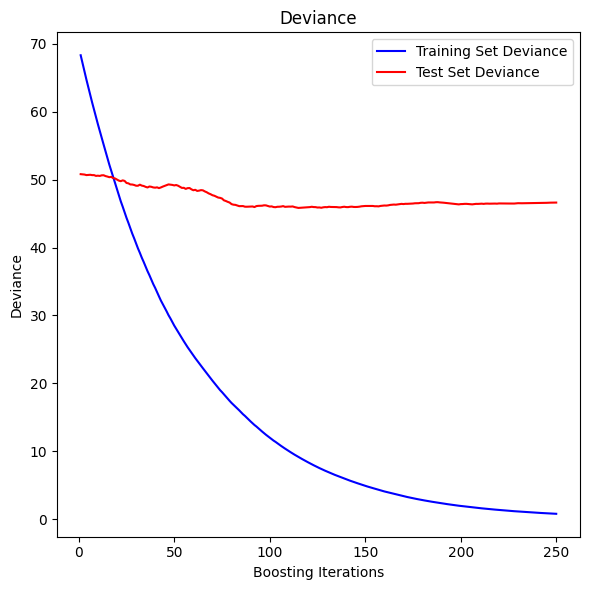

In [91]:
# Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

- Identifying relevant predictors

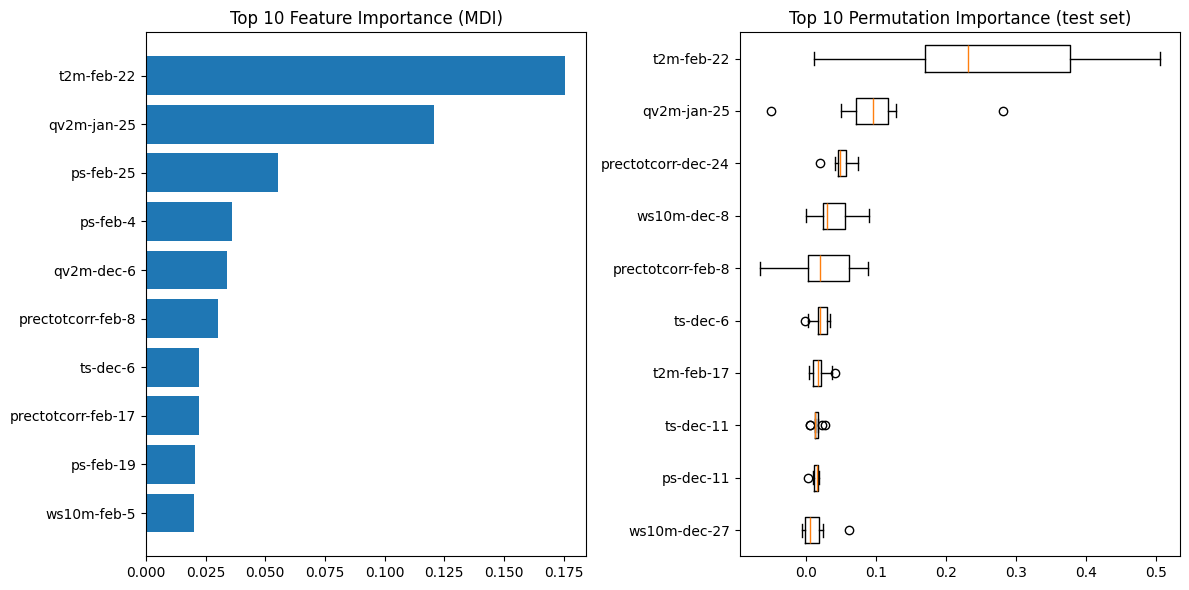

In [108]:
# Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
# Feature Importance (MDI)
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_10_idx_mdi = sorted_idx[-10:]  # Select the top 10 features based on MDI

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting Feature Importance (MDI)
pos = np.arange(len(top_10_idx_mdi)) + 0.5
ax[0].barh(pos, feature_importance[top_10_idx_mdi], align="center")
ax[0].set_yticks(pos)
ax[0].set_yticklabels(np.array(x.columns)[top_10_idx_mdi])
ax[0].set_title("Top 10 Feature Importance (MDI)")

# Permutation Importance (test set)
result = permutation_importance(
    reg, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx_perm = result.importances_mean.argsort()
top_10_idx_perm = sorted_idx_perm[-10:]  # Select the top 10 features based on permutation importance

# Plotting Permutation Importance (test set)
ax[1].boxplot(
    result.importances[top_10_idx_perm].T,
    vert=False,
    labels=np.array(x.columns)[top_10_idx_perm],
)
ax[1].set_title("Top 10 Permutation Importance (test set)")

fig.tight_layout()
plt.show()

- Plotting predicted values vs real values

In [143]:
# Creating Series for DF
trainingIndex = x_train.index
trainingPredY = pd.Series(reg.predict(x_train),index=trainingIndex)
trainingY = y_train

testingIndex = x_test.index
testingPredY = pd.Series(reg.predict(x_test),index=testingIndex)
testingY = y_test

# Creating Pandas DataFrame
trainingDf = pd.DataFrame({'bloom-doy-orig':trainingY,'bloom-doy-pred':trainingPredY})
testingDf = pd.DataFrame({'bloom-doy-orig':testingY,'bloom-doy-pred':testingPredY})

# Putting DF together
comparisonPlot = pd.concat([trainingDf,testingDf],ignore_index=False)
comparisonPlot.head(n=25)

# Getting location and year
comparisonPlotLocation = modelData.loc[comparisonPlot.index,'location']
comparisonPlotYear = modelData.loc[comparisonPlot.index,'year']
LocationYear = pd.DataFrame({'location':comparisonPlotLocation,'year':comparisonPlotYear})

# Adding data to comparison plot
comparisonPlot = pd.concat([comparisonPlot,LocationYear],axis=1)

# Create scatter plot with legend per location
fig = px.scatter(comparisonPlot, x='bloom-doy-orig', y='bloom-doy-pred', color='location', title='Bloom DOY Prediction',
                 labels={'bloom-doy-orig': 'Original Bloom DOY', 'bloom-doy-pred': 'Predicted Bloom DOY',})
                 #trendline='ols')

# Show the plot
fig.show()

## Prediction 2024 - Gradient Boosting Regression

- Gathering predictors for 2024

In [145]:
data2024 = weather[weather['year']==2024]
data2024

,year,location,t2m-dec-1,t2m-dec-10,t2m-dec-11,t2m-dec-12,t2m-dec-13,t2m-dec-14,t2m-dec-15,t2m-dec-16,...,ws10m-jan-29,ws10m-jan-3,ws10m-jan-30,ws10m-jan-31,ws10m-jan-4,ws10m-jan-5,ws10m-jan-6,ws10m-jan-7,ws10m-jan-8,ws10m-jan-9
215,2024,kyoto,4.93,11.08,10.82,12.44,6.58,8.58,14.62,12.09,...,2.51,2.45,0.79,2.29,4.53,3.20,3.52,6.45,4.14,2.98
216,2024,liestal,-0.77,5.78,8.18,8.31,5.30,3.68,2.70,1.00,...,1.96,10.23,2.24,1.99,5.98,2.21,2.49,5.09,6.20,3.70
217,2024,newyork,8.50,11.65,5.72,4.31,4.76,2.96,6.30,7.39,...,7.97,3.69,4.13,3.07,6.16,5.42,6.43,7.93,4.95,10.22
218,2024,vancouver,4.72,6.52,5.21,3.41,5.66,6.38,6.48,6.40,...,3.54,3.55,2.88,3.99,3.84,5.27,3.79,2.33,5.12,6.64
219,2024,washingtondc,5.06,10.76,2.19,0.83,1.83,0.93,3.72,5.04,...,6.82,2.55,3.07,1.95,5.17,2.87,4.78,5.05,3.23,8.78


- Making Predictions

In [146]:
reg.predict(data2024.drop(columns=['year','location']))

array([93.88937398, 85.08355621, 84.83331636, 84.00431038, 83.25508346])

## Estimating Prediction Intervals

- Using quatile regression using same parameters as previous regressor

In [153]:
# Empty Dictionary to store models
all_models = {}

# Using similar parameters as mse regressor
params2 = {
    "n_estimators": 250, # Value found after checking deviance plot
    "max_depth": 10,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    #"loss": "squared_error",
    "random_state":42
}

for alpha in [0.025, 0.5, 0.975]:
    gbr = ensemble.GradientBoostingRegressor(loss="quantile", alpha=alpha, **params2)
    all_models["q %1.3f" % alpha] = gbr.fit(x_train, y_train)

- Adding previous regressor

In [154]:
all_models['model'] = reg.fit(x_train, y_train)

- Calculating 95% Prediction Interval

In [158]:
# getiing values
y_pred = pd.Series(all_models['model'].predict(data2024.drop(columns=['year','location'])))
y_lower = pd.Series(all_models['q 0.025'].predict(data2024.drop(columns=['year','location'])))
y_upper = pd.Series(all_models['q 0.975'].predict(data2024.drop(columns=['year','location'])))
locations = pd.Series(['kyoto','liestal','new york','vancouver','washingtondc'])
# preparing DF
pd.DataFrame({'locations':locations,
              'lower':y_lower,
              'prediction':y_pred,
              'upper':y_upper})

,locations,lower,prediction,upper
0,kyoto,80.600277,93.889374,109.795829
1,liestal,75.159913,85.083556,109.795829
2,new york,81.902924,84.833316,109.850013
3,vancouver,78.353118,84.004310,109.795829
4,washingtondc,78.412401,83.255083,109.795829
